# Objective: To build a regression model using regularisation in order to predict the actual value of the properties.

In [578]:
#Importing liabraries for data processing and visualization
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [579]:
#Importing ML liabraries
from sklearn.model_selection import train_test_split      #For splitting into train-test set
from sklearn.linear_model import LinearRegression         #For building liner regression model
from sklearn.feature_selection import RFE                 #For feature selection
from sklearn.preprocessing import MinMaxScaler            #For scaling
from sklearn.metrics import r2_score, mean_squared_error  #For metrics evaluation
from sklearn.linear_model import Ridge                    #For building Ridge regression model  
from sklearn.linear_model import Lasso                    #For building Lasso regression model 
from sklearn.model_selection import GridSearchCV          #GridSearchCV for hyperparameter tuning

In [580]:
# Function to calculate metrics such as R2 score, RSS and RMSE and adj_r2
def metric_fun(X_train,y_train,X_test,y_test,regression) :   
    if regression == 'l':
        y_pred_train = lasso.predict(X_train)
        y_pred_test = lasso.predict(X_test)
    elif regression == 'r':
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
    metric = []
    r2_train_lr = r2_score(y_train, y_pred_train)
#     print(r2_train_lr)
    metric.append(r2_train_lr)

    r2_test_lr = r2_score(y_test, y_pred_test)
#     print(r2_test_lr)
    metric.append(r2_test_lr)

    rss1_lr = np.sum(np.square(y_train - y_pred_train))
#     print(rss1_lr)
    metric.append(rss1_lr)

    rss2_lr = np.sum(np.square(y_test - y_pred_test))
#     print(rss2_lr)
    metric.append(rss2_lr)

    mse_train_lr = mean_squared_error(y_train, y_pred_train)
#     print(mse_train_lr)
    metric.append(mse_train_lr**0.5)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
#     print(mse_test_lr)
    metric.append(mse_test_lr**0.5)

    adjusted_r_squared_train = 1 - (1-r2_train_lr)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
#     print(adjusted_r_squared_train)
    metric.append(adjusted_r_squared_train)

    adjusted_r_squared_test = 1 - (1-r2_test_lr)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
#     print(adjusted_r_squared_test)
    metric.append(adjusted_r_squared_test)
    
    return metric,y_pred_train,y_pred_test

In [581]:
def rfe_fun(X_train,y_train,num):
    lm = LinearRegression()           #Creating lm object using LinearRegression() 
    lm.fit(X_train,y_train)           #fit the model on training data
    rfe = RFE(lm,num)                 # Running RFE with the output number of the variable equal to num.
    rfe = rfe.fit(X_train,y_train)
    col = X_train.columns[rfe.support_]
    return col

In [582]:
#function to Bins month into quarters:
def month_binning(x):
    if x in [1,2,3]:
        return '1st_quarter'
    elif x in [4,5,6]:
        return '2nd_quarter'
    elif x in [7,8,9]:
        return '3rd_quarter'
    else:
        return '4th_quater' 

In [583]:
# functions to create Plots for residual analysis:
def residual_plot(y_train,y_pred_train):                
    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    sns.regplot(x=y_pred_train, y=(y_train - y_pred_train))  #Plots residuals versus predicted values
    plt.xlabel('predicted values')
    plt.ylabel('residuals')
    plt.title('residuals versus predicted values')
    plt.subplot(1,2,2)
    sns.distplot((y_train - y_pred_train))      #Plots Error Terms Distribution
    plt.title('Error Terms Distribution')
    plt.xlabel('Errors') 
    plt.show()
    
    
def prediction_plot(y_test,y_pred_test):   
    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    c = [i for i in range(len(y_test))]
    plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")       #Plotting actual observations
    plt.plot(c,y_pred_test, color="red",  linewidth=0.5, linestyle="-")  #Plotting predicted observations
    plt.title('Actual and Predicted')              
    plt.legend(['actual','predicted'])
    plt.xlabel('Index')                              
    plt.ylabel('cnt')
    plt.subplot(1,2,2)
    sns.regplot(x=y_test, y=y_pred_test)       #Actual versus predicted values
    plt.xlabel('observed values')
    plt.ylabel('predicted values')
    plt.title('observed versus predicted values')
    plt.show()

In [584]:
# Creates dataframe of beta coefficient values and respective predictors:
def betas(X_train,optimal,r):
    betas = pd.DataFrame(index=X_train.columns)
    betas.rows = X_train.columns
    betas[r] = optimal
    betas['abs_values']=abs(betas[r])
    return betas

#### Data Sourcing:
* The company has collected a data set from the sale of houses in Australia which is provided in the CSV file format as below :

In [585]:
df=pd.read_csv(r'C:\Users\ADMIN\Downloads\train.csv')
pd.set_option('display.max_columns', len(df.columns)) #Displays all the columns of dataframe in the output.
print(f'Dataframe has total {df.shape[0]} records and {df.shape[1]} number of initial predictors.')

Dataframe has total 1460 records and 81 number of initial predictors.


In [586]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [587]:
df_copy = df.copy()  #Making copy of original before modifying the dataframe.
print(df.Id.nunique())

1460


In [588]:
#As Id represents unique number representing a specific record it will not be helpful for prediction.
df.drop('Id',axis=1,inplace=True)  #Dropping Id column

In [589]:
df.info()    # Checking for missing values and dataypes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

#### Data cleaning : Treating Missing values

In [590]:
# Columns having missing values with their respective missing value percentage.
features_missing = round(df.isnull().sum()/len(df.index)*100,2)
features_missing = features_missing[features_missing!=0].sort_values(ascending=False)
print(features_missing)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64


In [591]:
# Displaying unique items and its counts for each categorical feature having missing values:
for i in features_missing.index:
    if i in list(df.select_dtypes(['object']).columns):
        print(f'{i} has {len(df[i].unique())} items which are {dict(df[i].value_counts())} & {dict(Nan=df[i].isnull().sum())}')

PoolQC has 4 items which are {'Gd': 3, 'Fa': 2, 'Ex': 2} & {'Nan': 1453}
MiscFeature has 5 items which are {'Shed': 49, 'Othr': 2, 'Gar2': 2, 'TenC': 1} & {'Nan': 1406}
Alley has 3 items which are {'Grvl': 50, 'Pave': 41} & {'Nan': 1369}
Fence has 5 items which are {'MnPrv': 157, 'GdPrv': 59, 'GdWo': 54, 'MnWw': 11} & {'Nan': 1179}
FireplaceQu has 6 items which are {'Gd': 380, 'TA': 313, 'Fa': 33, 'Ex': 24, 'Po': 20} & {'Nan': 690}
GarageType has 7 items which are {'Attchd': 870, 'Detchd': 387, 'BuiltIn': 88, 'Basment': 19, 'CarPort': 9, '2Types': 6} & {'Nan': 81}
GarageFinish has 4 items which are {'Unf': 605, 'RFn': 422, 'Fin': 352} & {'Nan': 81}
GarageQual has 6 items which are {'TA': 1311, 'Fa': 48, 'Gd': 14, 'Po': 3, 'Ex': 3} & {'Nan': 81}
GarageCond has 6 items which are {'TA': 1326, 'Fa': 35, 'Gd': 9, 'Po': 7, 'Ex': 2} & {'Nan': 81}
BsmtFinType2 has 7 items which are {'Unf': 1256, 'Rec': 54, 'LwQ': 46, 'BLQ': 33, 'ALQ': 19, 'GLQ': 14} & {'Nan': 38}
BsmtExposure has 5 items which

In [592]:
'''From data dictionary we can see that for following features missing value represent absence 
   of respective feature for that property e.g. missing value of Alley represents there is no 
   alley access for given property. Hence imputing missing values with 'NA' for below:        '''
None_level = [ 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish',
              'GarageQual','GarageCond']
for feature in None_level:
    df[feature] = df[feature].apply(lambda x:'NA' if pd.isnull(x) else x)

In [593]:
#Inspecting basement related missing values
df[((df['BsmtFinType2'].isnull()) | (df['BsmtExposure'].isnull()) | (df['BsmtFinType1'].isnull())   |  
   (df['BsmtCond'].isnull())      | (df['BsmtQual'].isnull()))][['BsmtFinType2','BsmtExposure',
   'BsmtFinType1','BsmtCond','BsmtQual','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

,BsmtFinType2,BsmtExposure,BsmtFinType1,BsmtCond,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0,0,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0,0,0
182,NaN,NaN,NaN,NaN,NaN,0,0,0,0
259,NaN,NaN,NaN,NaN,NaN,0,0,0,0
332,NaN,No,GLQ,TA,Gd,1124,479,1603,3206
342,NaN,NaN,NaN,NaN,NaN,0,0,0,0
362,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [594]:
'''For the record with index 332,the value of BsmtFinSF2 is 479. The closest mean value of 'BsmtFinSF2' 
   is 392.462963 which is for the level 'Rec'. Thus imputing missing value for 'BsmtFinType2' of 
   index 332 with 'Rec' (since its value is closest to mean value 'Rec' level).   '''

print(df.loc[332,['BsmtFinType2','BsmtFinSF2']])
df.groupby('BsmtFinType2')['BsmtFinSF2'].mean()

BsmtFinType2    NaN
BsmtFinSF2      479
Name: 332, dtype: object


BsmtFinType2
ALQ    626.157895
BLQ    329.909091
GLQ    658.000000
LwQ    310.739130
Rec    392.462963
Unf      0.000000
Name: BsmtFinSF2, dtype: float64

In [595]:
df.loc[332,'BsmtFinType2'] = 'Rec'

In [596]:
'''For index 948, we will impute missing value of 'BsmtExposure' feature with its mode value'''
df.loc[948,'BsmtExposure'] = df.BsmtExposure.mode()[0]

In [597]:
#Inspecting for remaining missing values for basement features:
df[(df[['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual','BsmtFinSF1','BsmtFinSF2',
        'BsmtUnfSF','TotalBsmtSF']].isnull().any(axis=1)) & (df['TotalBsmtSF']!=0)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [598]:
'''For all the records of Basement related features which are having missing values, their corresponding
   'TotalBsmtSF' i.e. total basement area is zero. representing absence of basement .i.e. NA.
   Hence imputing such values with 'NA' level.'''

Bsmt_list = ['BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual']
for feature in Bsmt_list:
    df[feature] = df[feature].apply(lambda x:'NA' if pd.isnull(x) else x)

In [599]:
# Binning and adding additional level representing missing values for the feature 'GarageYrBlt'
df.GarageYrBlt.quantile([0,.25,.5,.75,1])   #EDA for deciding the thresholds for each buckets

0.00    1900.0
0.25    1961.0
0.50    1980.0
0.75    2002.0
1.00    2010.0
Name: GarageYrBlt, dtype: float64

In [600]:
def GarageYrBlt_binning(x):
    if pd.isnull(x):
        return 'none/Na'
    elif x < 1900:
        return 'before 1900'
    elif 1900 <= x <= 1961:
        return '1900-1961'
    elif 1962 <= x <= 1980:
        return '1962-1980'
    elif 1981 <= x <= 2002:
        return '1981-2002'
    elif 2003 <= x <= 2010:
        return '2003-2010'
    else:
        return 'after 2010'    

In [601]:
df['GarageYrBlt'] = df.GarageYrBlt.apply(GarageYrBlt_binning)

In [602]:
# Handling missing values in 'MasVnrType' and 'MasVnrArea'.
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])   #Imputing missing value with mode
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].quantile(.5)) #Imputing missing value with median

In [603]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0]) #Imputing missing value with median

In [604]:
#Imputing LotFrontage missing values as per medians of corresponding lotshape.
df['LotFrontage'] = df.groupby('LotShape')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [605]:
# Columns having missing values with their respective missing value percentage.
features_missing = round(df.isnull().sum()/len(df.index)*100,2)
features_missing = features_missing[features_missing!=0].sort_values(ascending=False)
print(features_missing)
#We have imputed all the missing values.

Series([], dtype: float64)


#### Deriving new features:

In [606]:
df['yrs_since_built'] = (dt.date.today().year) - (df['YearBuilt'])  #Age of the house
df['yrs_since_renovated'] = (dt.date.today().year) - (df['YearRemodAdd'])  #years since last rennovated.
df.drop(['YearBuilt','YearRemodAdd'],axis=1,inplace=True) #Dropping original columns to avoid multicollinearity.

In [607]:
df['TotBathrmsAbvGrd'] = df['FullBath'] + df['HalfBath'] #Represents total bathrroms that are above grade.

In [608]:
'''MSSubClass seems like nominal categorical variable, thus coverting it into a categorical variable.'''
df['MSSubClass'] = df.MSSubClass.astype('str')

#### EDA and Data visulalization:

In [609]:
df.describe(percentiles=[.25,.5,.75,.9,.99])

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,yrs_since_built,yrs_since_renovated,TotBathrmsAbvGrd
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.382534,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,49.732192,36.134247,1.947945
std,22.404624,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,30.202904,20.645407,0.794965
min,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,11.000000,11.000000,0.000000
25%,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,21.000000,17.000000,1.000000
50%,70.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,48.000000,27.000000,2.000000
75%,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,67.000000,54.000000,3.000000
90%,92.000000,14381.700000,8.000000,7.000000,335.000000,1065.500000,117.200000,1232.000000,1602.200000,1680.000000,954.200000,0.000000,2158.300000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,9.000000,1.000000,3.000000,757.100000,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,2010.000000,278000.000000,96.100000,71.000000,3.000000
99%,142.230000,37567.640000,10.000000,9.000000,791.280000,1572.410000,830.380000,1797.050000,2155.050000,2219.460000,1418.920000,360.000000,3123.480000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,11.000000,2.000000,3.000000,1002.790000,505.460000,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,12.000000,2010.000000,442567.010000,121.820000,71.000000,4.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,

In [610]:
# #Commenting the code to reduce runtime.(to uncomment press cntrl+a to select all and then ctrl + /)
# #frequency distribution of categorical variables
# for i in list(df.select_dtypes('object').columns):
#     sns.histplot(df[i])
#     plt.xlabel(i)
#     plt.xticks(rotation=90)
#     plt.show()

In [611]:
# #Commenting the code to reduce runtime.(to uncomment press cntrl+a to select all and then ctrl + /)
## Distribution of categorical variables against target variable i.e.SalePrice
# for i in list(df.select_dtypes('object').columns):
#     plt.figure(figsize=[15,6])
#     sns.boxplot(y=df['SalePrice'],x=df[i])
#     plt.xlabel(i)
#     plt.xticks(rotation=90)
#     plt.show()

In [612]:
# #Commenting the code to reduce runtime.(to uncomment press cntrl+a to select all and then ctrl + /)
## Distribution of quantitative variables
# for i in list(df.select_dtypes(exclude='object').columns):
#     sns.boxplot(data=df[i])
#     plt.xlabel(i)
#     plt.show()

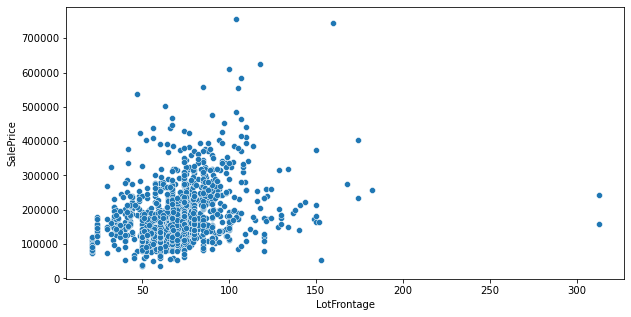

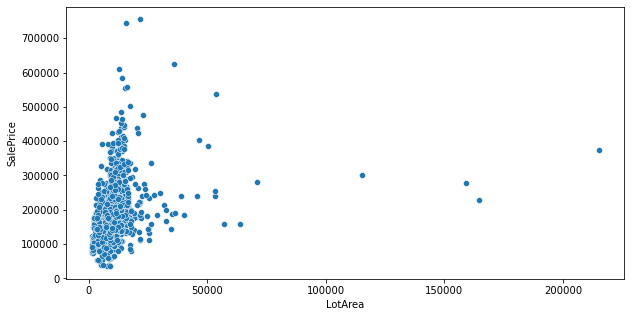

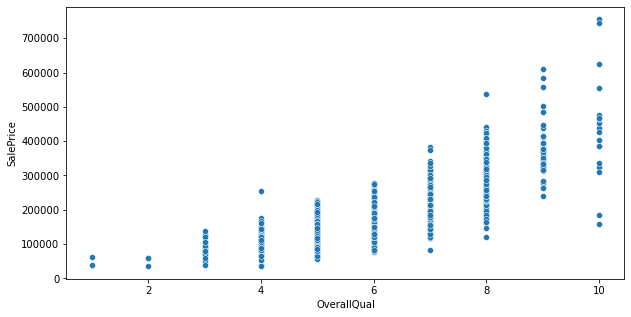

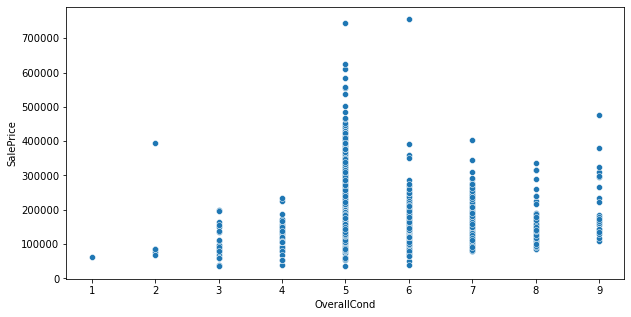

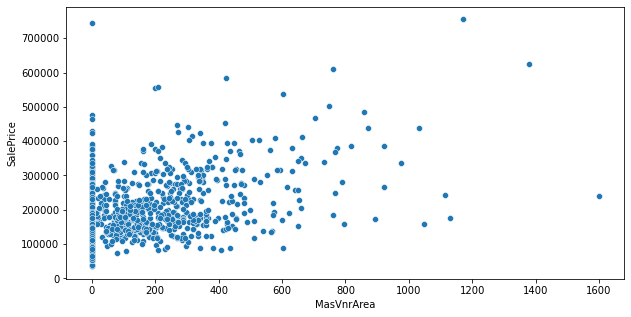

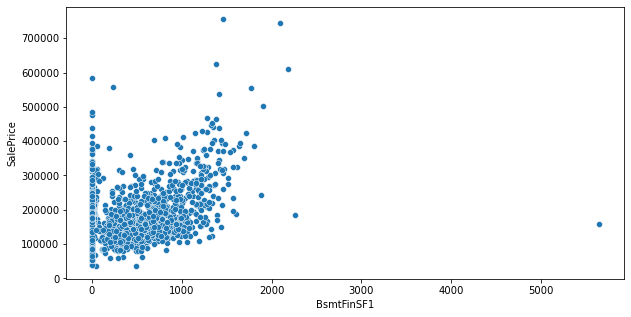

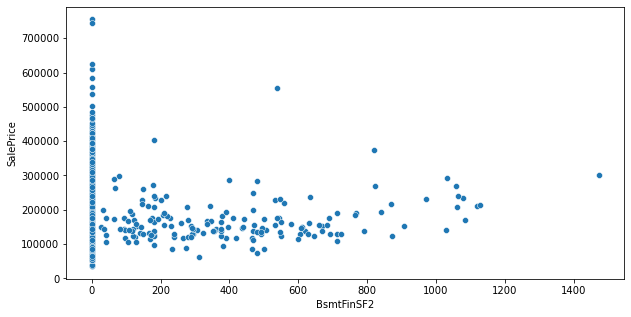

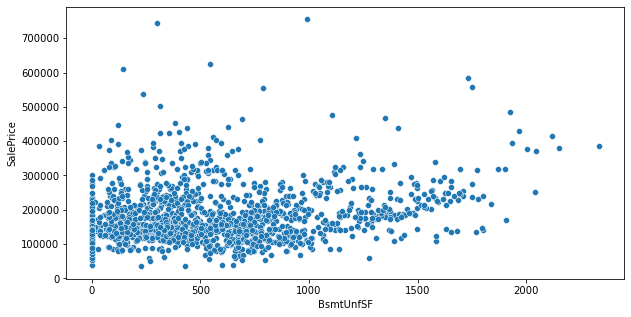

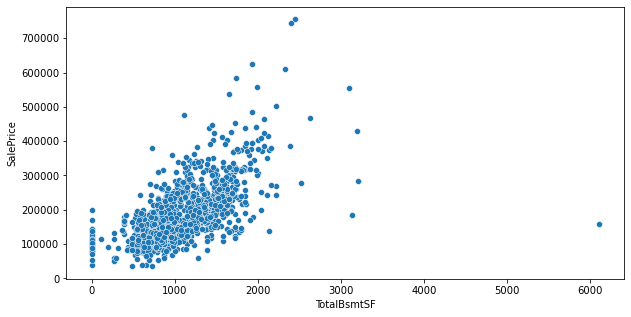

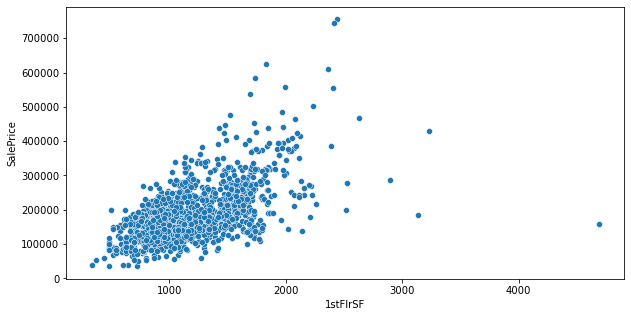

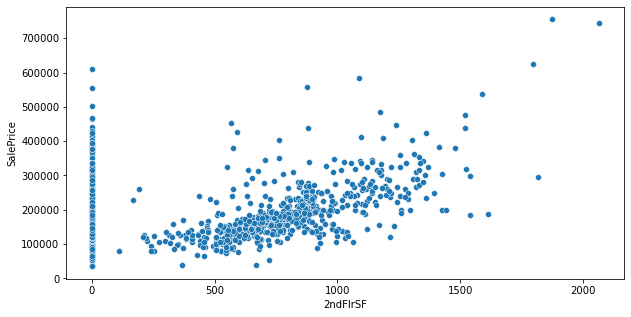

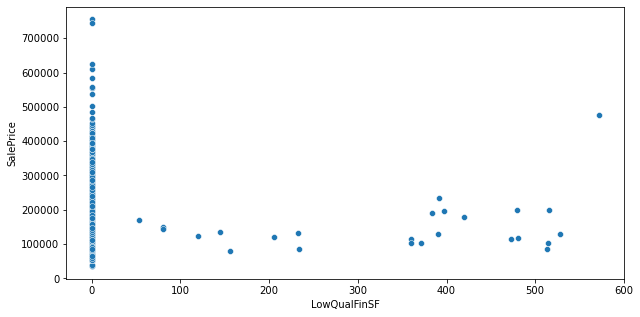

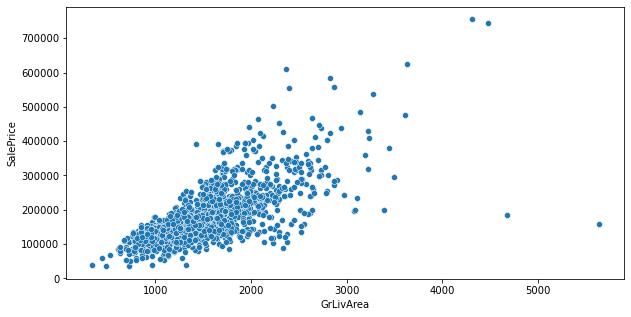

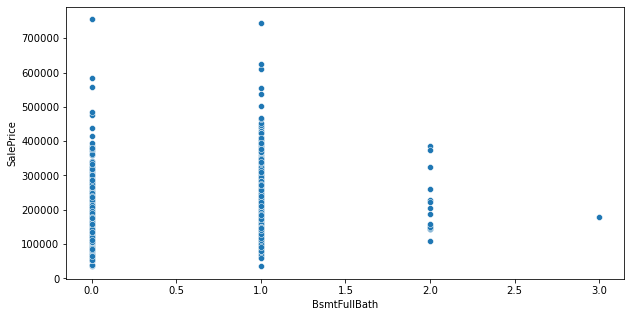

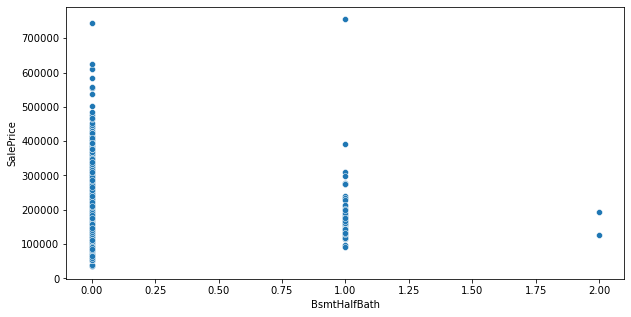

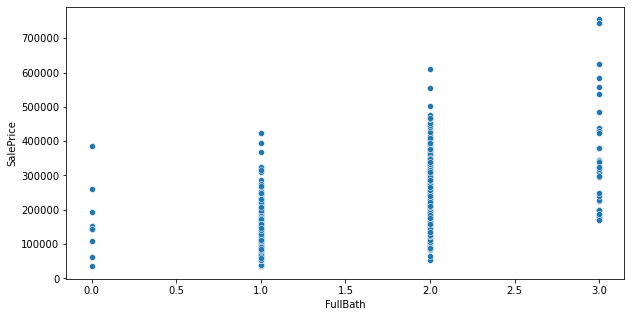

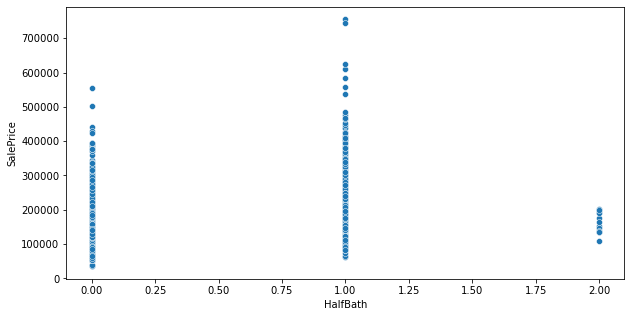

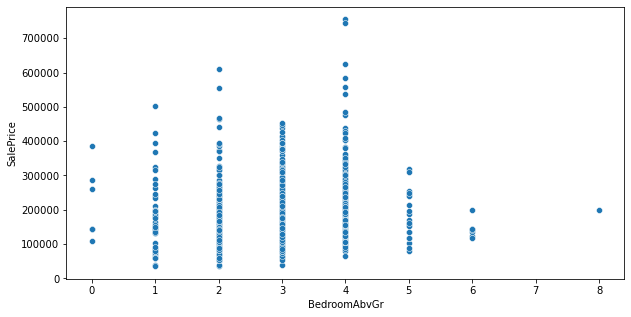

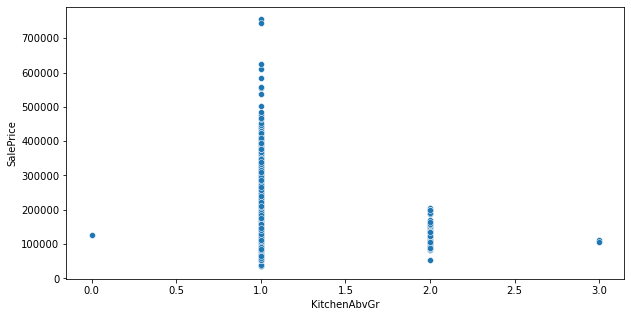

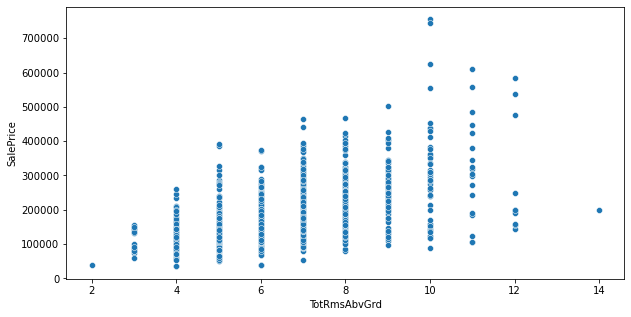

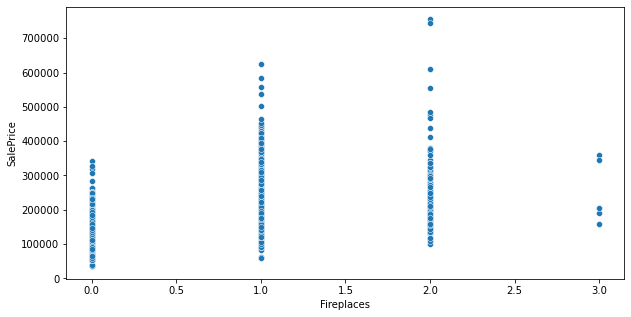

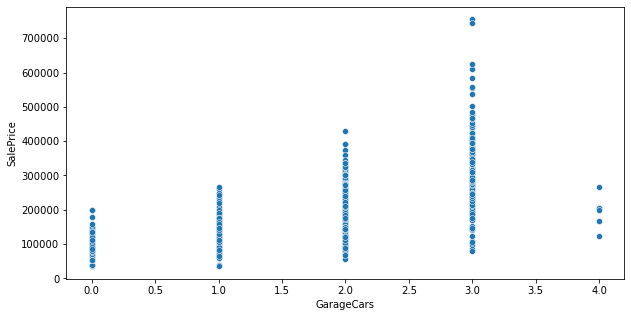

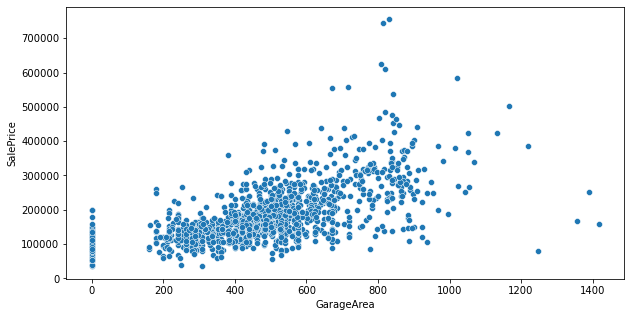

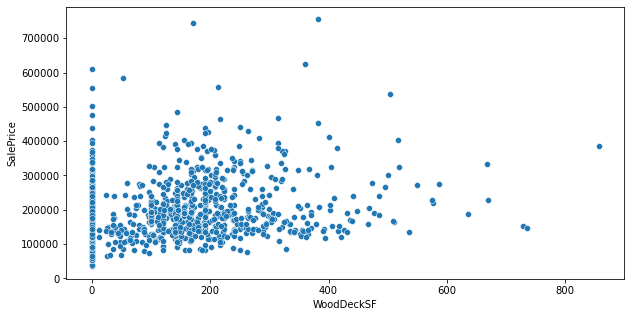

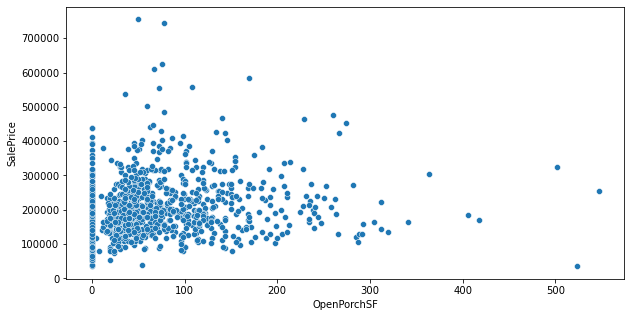

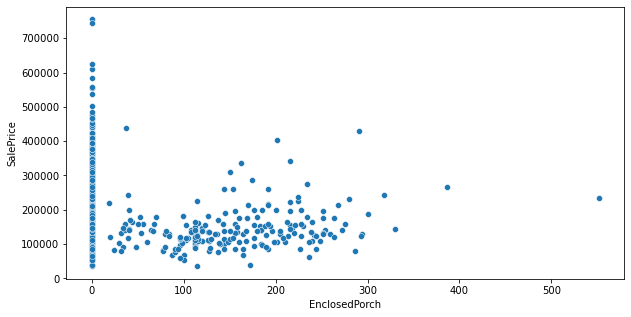

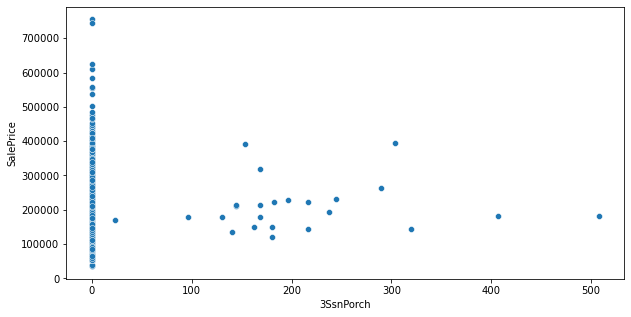

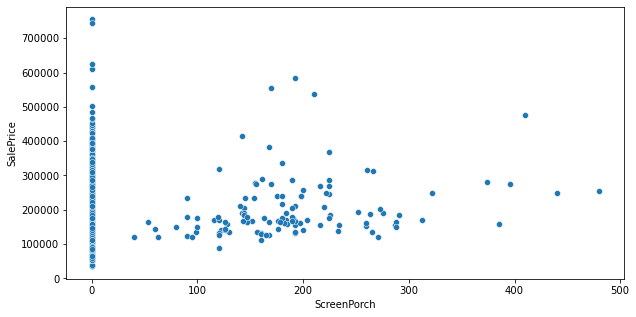

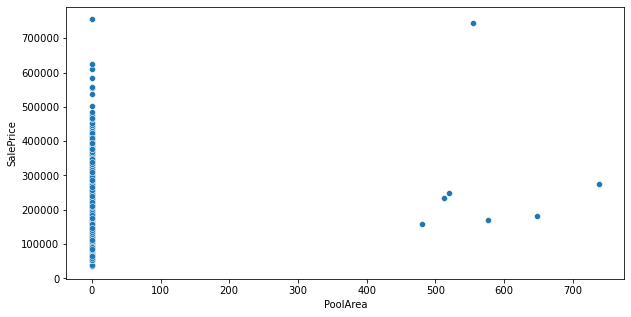

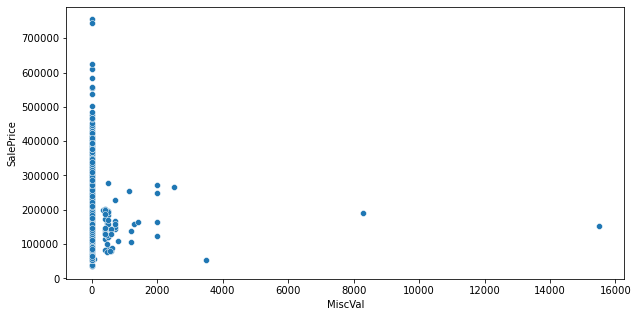

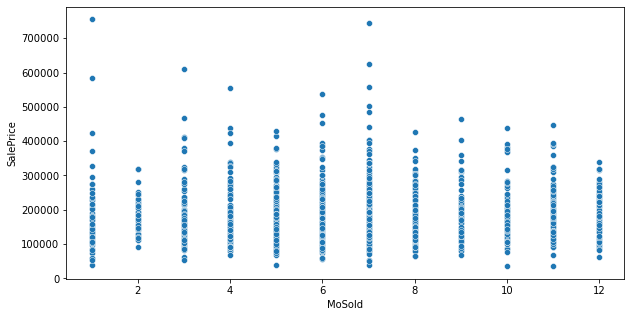

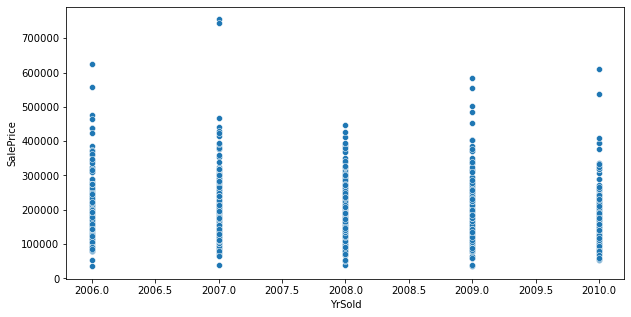

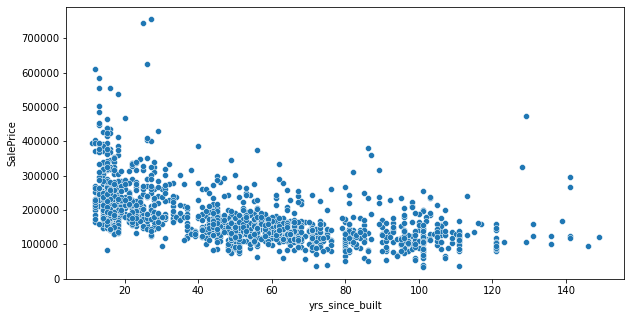

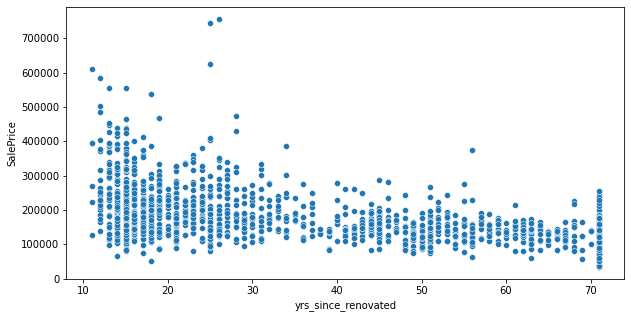

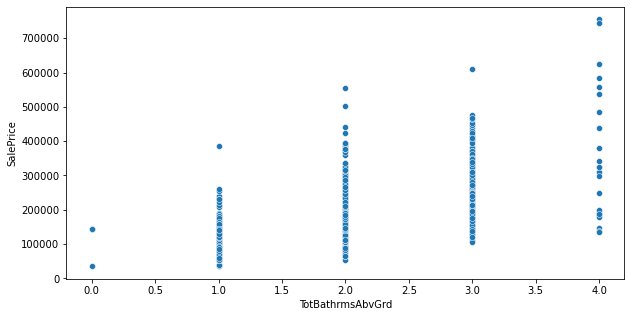

In [613]:
##Distribution of quantitative variables against target variable i.e.SalePrice
for i in list(df.select_dtypes(exclude='object').columns):
    if i!='SalePrice':
        plt.figure(figsize=[10,5])
        sns.scatterplot(x=df[i],y=df['SalePrice'])
        plt.show()

We can see linear relationship between Target variable SalePrice and some of the predictors such as Overall quality,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,TotBathrmsAbvGrd etc.

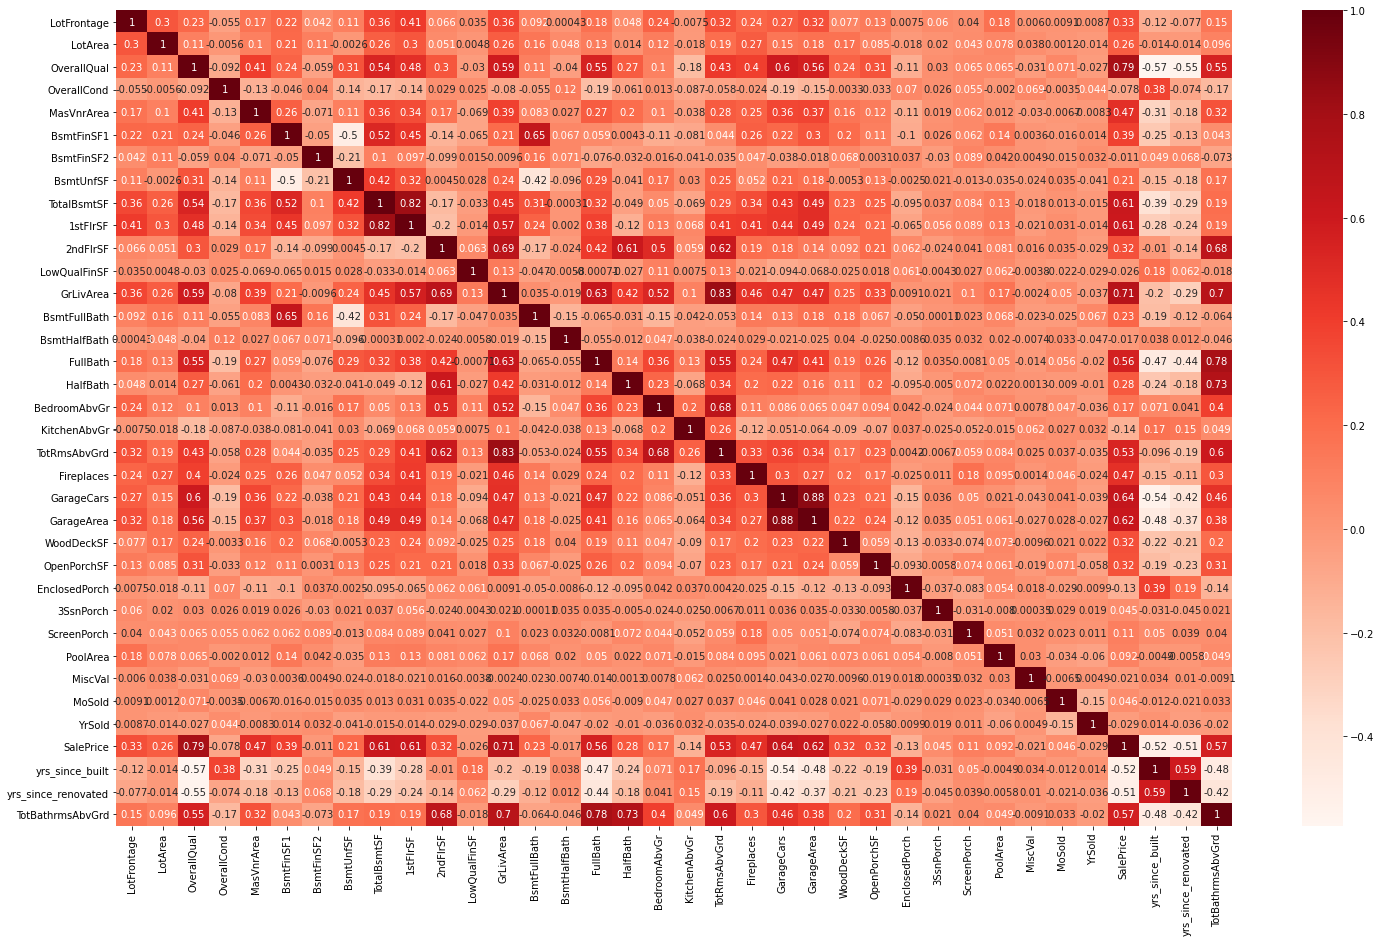

In [614]:
#Checking for correlation between target and predictors as well as for collinearity among predictors.
plt.figure(figsize=[25,15])
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds, annot=True)
plt.show()

There are some predictors which are correlated with other predictors e.g. GarageCars and  GarageArea, 1stFlrSF and TotalBsmtSF , GrLivArea and TotRmsAbvGrd.
There is multicollinearity present in the data. Regularization will help us here as well.

In [615]:
cor = df.corr()
cor_target = abs(cor["SalePrice"])
relevant_features = cor_target[cor_target>0.5]
relevant_features.sort_values(ascending=False)

SalePrice              1.000000
OverallQual            0.790982
GrLivArea              0.708624
GarageCars             0.640409
GarageArea             0.623431
TotalBsmtSF            0.613581
1stFlrSF               0.605852
TotBathrmsAbvGrd       0.568267
FullBath               0.560664
TotRmsAbvGrd           0.533723
yrs_since_built        0.522897
yrs_since_renovated    0.507101
Name: SalePrice, dtype: float64

OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,TotBathrmsAbvGrd etc. are some of the highest correlated predictors with our target variable i.e., SalePrice.

#### Data preperation:

In [616]:
''''Since we may not have 'YrSold' data with us when predicting prices of new properties as these are not 
    sold yet, it will not help us much. Hence we will drop it.
    On the other hand, Months may have impact on prices as per economic seasonal trends and festivals hence
    we will keep MoSold                                         '''

df.drop(['YrSold'],axis=1,inplace=True)

In [617]:
df['MoSold'] = df['MoSold'].apply(month_binning) #binning months into four quarters of year.

In [618]:
''' To avoid having very large number of dummy variables, we will label encode 'Ordinal' predictors.'''
ordinal_features1 = ['ExterQual','ExterCond','HeatingQC','KitchenQual']
for i in ordinal_features1:
    df[i]=df[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    
ordinal_features2 = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond']
for i in ordinal_features2:
    df[i]=df[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
    
ordinal_features3 = ['BsmtFinType1','BsmtFinType2']
for i in ordinal_features3:
    df[i]=df[i].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
    
df['BsmtExposure']=df['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0})
df['GarageFinish']=df['GarageFinish'].map({'Fin':3,'RFn':2,'Unf':1,'NA':0})
df['PoolQC']=df['PoolQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0})

#### Outlier treatment:

In [619]:
outlier_treatment = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GarageArea','WoodDeckSF',
                     'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']
for feature in outlier_treatment:
    upper_lim = df[feature].quantile(0.99)
    lower_lim = df[feature].quantile(0.01)
    df = df[df[feature].between(lower_lim, upper_lim)]

In [620]:
# #Commenting the code to reduce runtime.(to uncomment press ctrl+a to select all and then ctrl+/)
# #Checking distribution after removing outliers
# for i in list(df.select_dtypes(exclude='object').columns):
#     if i!='SalePrice':
#         plt.figure(figsize=[10,5])
#         sns.scatterplot(x=df[i],y=df['SalePrice'])
#         plt.show()

### Dummy variables creation :

In [621]:
y = df.pop('SalePrice')  #extracting target variable from train set
X = df            #extracting predictors from train set

In [622]:
dummy_list = list(X.select_dtypes('object').columns)
dummies = pd.get_dummies(X[dummy_list],drop_first=True) #Creating dummies & Dropping one of the levels since it's redundant.
X.drop(dummy_list,axis=1,inplace=True)  #Droping original columns after extracting dummy variables 
X = pd.concat([X,dummies],axis = 1)     #Concating dummy variables to original dataframe
X.shape

(1181, 222)

### Data transformation:

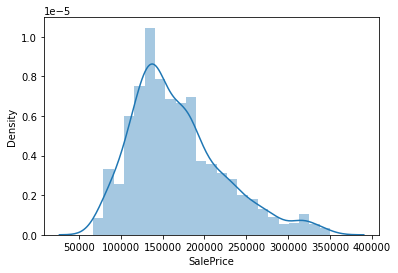

In [623]:
sns.distplot(y,kde=True)
plt.show()

In [624]:
print(skew(y))

0.8739490280062343


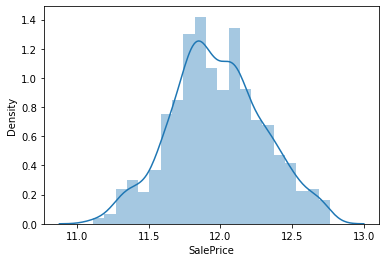

In [625]:
"""As we can see target variable is right skewed. We will try log transformation of target variable"""
sns.distplot(np.log(y),kde=True)
plt.show()

In [626]:
"""From above we can see that skewness is reduced significantly after log transformation. 
   Thus we will log transform the target variable."""
print('skewness after log transformation of target variable: ',skew(y))
y = np.log(y)        #Data Transformation

skewness after log transformation of target variable:  0.8739490280062343


### Train-Test split :

In [627]:
# Spltting data such that training and test data corresponds to 70% and 30% of original dataset resp.
# We specify this for our convinience so that the train and test data set always have the same rows.
np.random.seed(0)  #To initialize a pseudorandom number generator.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

### Scaling before regularization :

In [628]:
scaler = MinMaxScaler()  # Creating a scaler object using StandardScaler()
#'transform' and 'Fit' the train set
X_train[list(X_train.columns)]=scaler.fit_transform(X_train[list(X_train.columns)]) 

In [629]:
#transform only on test set
X_test[list(X_test.columns)]=scaler.transform(X_test[list(X_test.columns)]) 

In [630]:
#Creating copy for future use
X_train_cpy, y_train_cpy, X_test_cpy, y_test_cpy = X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy()  

#### Feature selection using RFE

In [631]:
col = rfe_fun(X_train,y_train,50)   #getting top 50 features selected by RFE

X_train, y_train= X_train_cpy.copy(), y_train_cpy.copy()
X_test, y_test= X_test_cpy.copy(), y_test_cpy.copy()

X_train = X_train[col]              #Selecting top 50 features selected by RFE
X_test = X_test[col]

## <font color=orange>Hyperparameter tuning using cross validation grid search for Ridge regression:</font>

In [632]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 1.0, 1.1,
 1.4, 1.449, 1.450, 1.451, 1.4511, 1.455, 1.499, 1.5, 1.501, 1.599, 1.7, 1.9, 2.0, 
 2.5, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()                                             # Creating a ridge object of class Ridge()

# cross validation
folds = 10                                                  # creates 10 folds  
model_cv = GridSearchCV(estimator = ridge,                  # ridge estimator
                        param_grid = params,                # Fetching list of hyperparameter values to try
                        scoring= 'neg_mean_absolute_error', # evalution metric 
                        cv = folds,                         # Determines the cross-validation splitting strategy
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)                              #Fitting the model to get optimized alpha.

# Printing the best hyperparameter alpha
print(model_cv.best_params_)

Fitting 10 folds for each of 37 candidates, totalling 370 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 1.0}


[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    1.4s finished


In [633]:
alpha_ridge = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha_ridge)              # Initializing the Ridge Regression model with a specific alpha
ridge.fit(X_train, y_train)             # fit the model on the features
ridge_optimal = ridge.coef_
print(ridge.coef_)                      # prints model coefficients

[ 0.13372231  0.41947974  0.25852567  0.15805468  0.04329229  0.0475598
  0.18268234  0.2103454   0.207844   -0.05653375  0.23346567  0.03983806
  0.02662106 -0.18148506  0.1186342   0.1820091   0.          0.
 -0.39937757  0.04318907 -0.1217982  -0.01330918 -0.03657197  0.16925823
  0.03820935  0.1038933   0.06898406  0.         -0.05448785 -0.11331284
  0.          0.1768121  -0.14260631 -0.01243775  0.02204007 -0.04709747
  0.         -0.03657197  0.02418597  0.15196955 -0.04545507 -0.01909826
 -0.01909826  0.07713839  0.06767156  0.02144053  0.08489241 -0.14066442
  0.04991278  0.10601672]


In [634]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
metric1,y_pred_train,y_pred_test = metric_fun(X_train,y_train,X_test,y_test,'r')

In [635]:
betas_ridge_optimal = betas(X_train,ridge_optimal,'ridge')
betas_ridge_optimal.sort_values(by='abs_values',ascending=False)[:5]

,ridge,abs_values
OverallQual,0.419480,0.419480
yrs_since_built,-0.399378,0.399378
OverallCond,0.258526,0.258526
GrLivArea,0.233466,0.233466
1stFlrSF,0.210345,0.210345


In [636]:
betas_ridge_top5 = list(betas_ridge_optimal.sort_values(by='abs_values',ascending=False)[:5].index)
print(f'Top 5 features are: ',betas_ridge_top5)

Top 5 features are:  ['OverallQual', 'yrs_since_built', 'OverallCond', 'GrLivArea', '1stFlrSF']


In [637]:
betas_ridge_optimal[betas_ridge_optimal['ridge']!=0]  #Beta coefficients of model

,ridge,abs_values
LotArea,0.133722,0.133722
OverallQual,0.419480,0.419480
OverallCond,0.258526,0.258526
BsmtFinSF1,0.158055,0.158055
BsmtFinSF2,0.043292,0.043292
BsmtUnfSF,0.047560,0.047560
TotalBsmtSF,0.182682,0.182682
1stFlrSF,0.210345,0.210345
2ndFlrSF,0.207844,0.207844
LowQualFinSF,-0.056534,0.056534


#### <font color=pink>Residual analysis for checking assumptions of linear regression.</font>

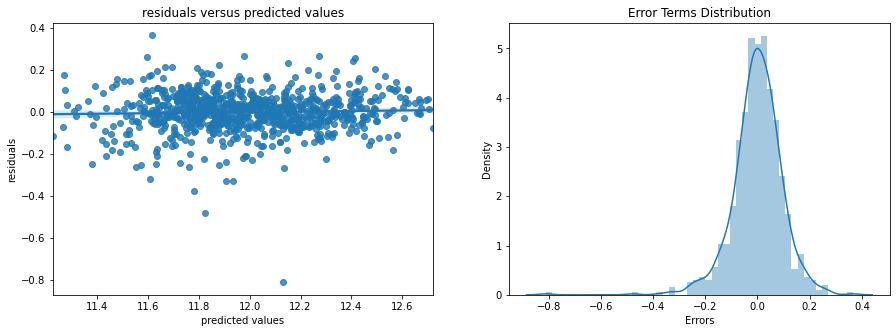

In [638]:
residual_plot(y_train,y_pred_train)

##### <font color=pink>From above:</font>
    * We can see that error terms are normally distributed with mean around zero.
    * error terms are independent of each other as we dont see any pattern.
    * error terms have approximately constant variance.

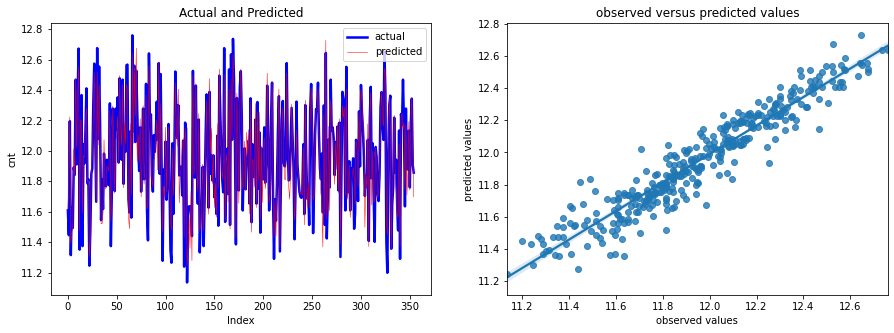

In [639]:
prediction_plot(y_test,y_pred_test)

##### <font color=pink>From above:</font>
    We can see that observed and predicted values follow the same trend are overlapping suggesting a good fit.

##### <font color=pink> Thus assumptions of linear regressions are validated.</font>

## <font color=orange> Hyperparameter tuning using cross validation grid search for Lasso regression:</font>

In [640]:
X_train, y_train= X_train_cpy.copy(), y_train_cpy.copy()
X_test, y_test= X_test_cpy.copy(), y_test_cpy.copy()

In [641]:
X_train = X_train[col]
X_test = X_test[col]

In [642]:
params = {'alpha': [0.00009, 0.0001, 0.0005, 0.0009 , 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 1.0, 1.1,
 1.4, 1.449, 1.450, 1.451, 1.4511, 1.455, 1.499, 1.5, 1.501, 1.599, 1.7, 1.9, 2.0, 
 2.5, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()                                           # Creating a lasso object of class lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso,                # lasso estimator
                        param_grid = params,              # Fetching a list of hyperparameter values to try
                        scoring= 'neg_mean_absolute_error',  # evalution metric
                        cv = folds,                          #folds = 10
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)                              #Fitting the model to get optimized alpha.
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.0005}


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished


In [643]:
alpha_lasso = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha_lasso)              # Initializing the lasso Regression model with a specific alpha
lasso.fit(X_train, y_train)             # fit the model on the features
lasso_optimal = lasso.coef_
print(lasso.coef_)                      # prints model coefficients

[ 1.08994139e-01  4.42473744e-01  2.62903089e-01  1.13924023e-01
  1.16398425e-03 -0.00000000e+00  2.28361096e-01  0.00000000e+00
  6.03002476e-03 -0.00000000e+00  6.00947327e-01  0.00000000e+00
  9.45686613e-03 -1.00786645e-01  1.04905067e-01  1.74996974e-01
  0.00000000e+00  0.00000000e+00 -4.27124192e-01  5.38926018e-02
 -1.10643019e-01  0.00000000e+00 -8.04142316e-02  9.39748635e-02
 -0.00000000e+00  4.36512509e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.71759714e-01
 -1.06725549e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -5.57856270e-05  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  8.17264761e-03
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [644]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
metric2,y_pred_train,y_pred_test = metric_fun(X_train,y_train,X_test,y_test,'l')

In [645]:
betas_lasso_optimal = betas(X_train,lasso_optimal,'lasso')
betas_lasso_optimal.sort_values(by='abs_values',ascending=False)[:5]

,lasso,abs_values
GrLivArea,0.600947,0.600947
OverallQual,0.442474,0.442474
yrs_since_built,-0.427124,0.427124
OverallCond,0.262903,0.262903
TotalBsmtSF,0.228361,0.228361


In [646]:
betas_lasso_top5 = list(betas_lasso_optimal.sort_values(by='abs_values',ascending=False)[:5].index)
print(f'Top 5 features are: ',betas_lasso_top5)

Top 5 features are:  ['GrLivArea', 'OverallQual', 'yrs_since_built', 'OverallCond', 'TotalBsmtSF']


In [647]:
betas_lasso_optimal[betas_lasso_optimal['lasso']!=0]

,lasso,abs_values
LotArea,0.108994,0.108994
OverallQual,0.442474,0.442474
OverallCond,0.262903,0.262903
BsmtFinSF1,0.113924,0.113924
BsmtFinSF2,0.001164,0.001164
TotalBsmtSF,0.228361,0.228361
2ndFlrSF,0.006030,0.006030
GrLivArea,0.600947,0.600947
HalfBath,0.009457,0.009457
KitchenAbvGr,-0.100787,0.100787


#### <font color=pink>Residual analysis for checking assumptions of linear regression.</font>

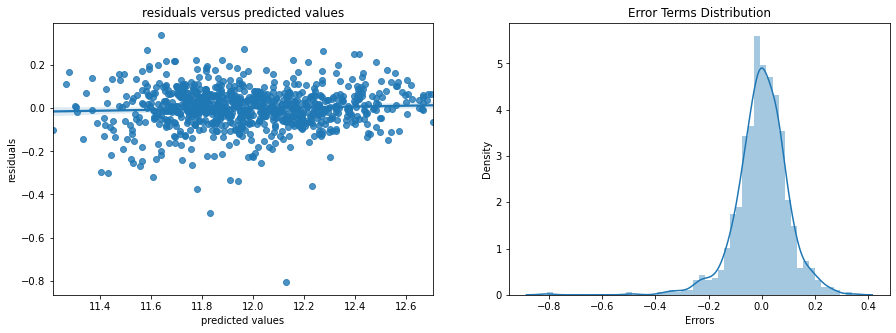

In [648]:
residual_plot(y_train,y_pred_train)

##### <font color=pink>From above:</font>
    * We can see that error terms are normally distributed with mean around zero.
    * error terms are independent of each other as we dont see any pattern.
    * error terms have approximately constant variance.

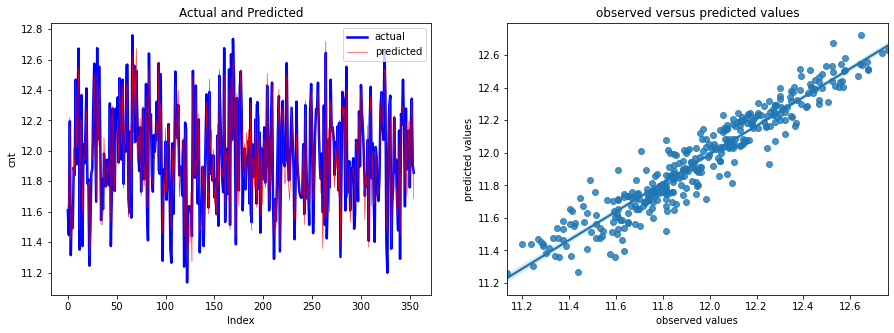

In [649]:
prediction_plot(y_test,y_pred_test)

##### <font color=pink>From above:</font>
    We can see that observed and predicted values follow the same trend are overlapping suggesting a good fit.

##### <font color=pink> Thus assumptions of linear regressions are validated.</font>

### Score comparison of ridge and lasso:

In [650]:
# Creating a table which contain all the metrics score for comparison
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)','adj_r2 (Train)', 'adj_r2 (Test)'], 
            'Ridge Reg(optimal alpha)': metric1}

rg_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Ridge Reg(optimal alpha)'] )
ls_metric = pd.Series(metric2, name = 'Lasso Reg(optimal alpha)')

optimal_metric = pd.concat([rg_metric, ls_metric], axis = 1)
optimal_metric

,Metric,Ridge Reg(optimal alpha),Lasso Reg(optimal alpha)
0,R2 Score (Train),0.907252,0.901365
1,R2 Score (Test),0.902457,0.902834
2,RSS (Train),7.452680,7.925734
3,RSS (Test),3.983973,3.968601
4,MSE (Train),0.094987,0.097956
5,MSE (Test),0.105936,0.105732
6,adj_r2 (Train),0.901269,0.895002
7,adj_r2 (Test),0.886414,0.886852


## <font color=orange>Building the model with double the optimal value of alpha</font>

* Changes for Ridge regression for double the optimal value of alpha:

In [651]:
X_train, y_train= X_train_cpy.copy(), y_train_cpy.copy()
X_test, y_test= X_test_cpy.copy(), y_test_cpy.copy()
X_train = X_train[col]
X_test = X_test[col]

In [652]:
ridge = Ridge(alpha=(2*alpha_ridge))              # Initializing the Ridge Regression model with a specific alpha
ridge.fit(X_train, y_train)             # fit the model on the features
ridge_2Xoptimal = ridge.coef_
print(ridge.coef_)                      # prints model coefficients

[ 0.11954995  0.40684023  0.23702143  0.15964522  0.03970005  0.04976874
  0.18450274  0.20260543  0.19850661 -0.04131376  0.22521269  0.04970822
  0.03296983 -0.14655015  0.12848691  0.18423372  0.          0.
 -0.3741757   0.05376608 -0.11936327 -0.00509581 -0.04127042  0.13352551
  0.00908815  0.07383185  0.03358205  0.         -0.03483566 -0.06508223
  0.          0.17250703 -0.1267915  -0.01081793  0.02425821 -0.0310362
  0.         -0.04127042  0.01250012  0.08665234 -0.02619785 -0.01600409
 -0.01600409  0.06001968  0.03919702  0.00317436  0.04705611 -0.10856023
  0.02916632  0.07485294]


In [653]:
metric3,y_pred_train,y_pred_test = metric_fun(X_train,y_train,X_test,y_test,'r')

In [654]:
betas_ridge_2Xoptimal = betas(X_train,ridge_2Xoptimal,'ridge')
betas_ridge_2Xoptimal.sort_values(by='abs_values',ascending=False)[:5]

,ridge,abs_values
OverallQual,0.406840,0.406840
yrs_since_built,-0.374176,0.374176
OverallCond,0.237021,0.237021
GrLivArea,0.225213,0.225213
1stFlrSF,0.202605,0.202605


In [655]:
print(f'Top 5 features are: ',list(betas_ridge_2Xoptimal.sort_values(by='abs_values',ascending=False)[:5].index))

Top 5 features are:  ['OverallQual', 'yrs_since_built', 'OverallCond', 'GrLivArea', '1stFlrSF']


* Changes for lasso regression for double the optimal value of alpha

In [656]:
X_train, y_train= X_train_cpy.copy(), y_train_cpy.copy()
X_test, y_test= X_test_cpy.copy(), y_test_cpy.copy()
X_train = X_train[col]
X_test = X_test[col]

In [657]:
lasso = Lasso(alpha=(2*alpha_lasso))              # Initializing the lasso Regression model with a specific alpha
lasso.fit(X_train, y_train)             # fit the model on the features
lasso_2Xoptimal = lasso.coef_
print(lasso.coef_)                      # prints model coefficients

[ 7.37256210e-02  4.56803963e-01  2.30941883e-01  1.10729382e-01
  0.00000000e+00  0.00000000e+00  2.23316218e-01  0.00000000e+00
  2.69516523e-03 -0.00000000e+00  5.86718569e-01  0.00000000e+00
  1.81493503e-02 -0.00000000e+00  1.12195618e-01  1.72945215e-01
  0.00000000e+00  0.00000000e+00 -4.09142107e-01  4.00177138e-02
 -9.61601102e-02 -0.00000000e+00 -9.56007351e-02  7.46220892e-02
 -0.00000000e+00  4.27502045e-02 -5.10750465e-03  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.61511770e-01
 -5.38383242e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -6.02854136e-05 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [658]:
metric4,y_pred_train,y_pred_test = metric_fun(X_train,y_train,X_test,y_test,'l')

In [659]:
betas_lasso_2Xoptimal = betas(X_train,lasso_2Xoptimal,'lasso')
betas_lasso_2Xoptimal.sort_values(by='abs_values',ascending=False)[:5]

,lasso,abs_values
GrLivArea,0.586719,0.586719
OverallQual,0.456804,0.456804
yrs_since_built,-0.409142,0.409142
OverallCond,0.230942,0.230942
TotalBsmtSF,0.223316,0.223316


In [660]:
print(f'Top 5 features are: ',list(betas_lasso_2Xoptimal.sort_values(by='abs_values',ascending=False)[:5].index))

Top 5 features are:  ['GrLivArea', 'OverallQual', 'yrs_since_built', 'OverallCond', 'TotalBsmtSF']


## <font color=orange>Building model after removing top 5 features:</font>

* Building ridge model after removing top 5 features:

In [661]:
X_train, y_train= X_train_cpy.copy(), y_train_cpy.copy()
X_test, y_test= X_test_cpy.copy(), y_test_cpy.copy()

In [662]:
X_train.drop(betas_ridge_top5,axis=1,inplace=True)
X_test.drop(betas_ridge_top5,axis=1,inplace=True)

In [663]:
# Performing feature selection with rfe:
col = rfe_fun(X_train,y_train,50)
X_train = X_train[col]
X_test = X_test[col]

In [664]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 1.0, 1.1,
 1.4, 1.449, 1.450, 1.451, 1.4511, 1.455, 1.499, 1.5, 1.501, 1.599, 1.7, 1.9, 2.0, 
 2.5, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()                                             # Creating a ridge object of class Ridge()

# cross validation
folds = 10                                                  # creates 10 folds  
model_cv = GridSearchCV(estimator = ridge,                  # ridge estimator
                        param_grid = params,                # Fetching list of hyperparameter values to try
                        scoring= 'neg_mean_absolute_error', # evalution metric 
                        cv = folds,                         # Determines the cross-validation splitting strategy
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)                              #Fitting the model to get optimized alpha.

# Printing the best hyperparameter alpha
print(model_cv.best_params_)

Fitting 10 folds for each of 37 candidates, totalling 370 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.05}


[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    1.4s finished


In [665]:
alpha_ridge_new = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha_ridge_new)              # Initializing the Ridge Regression model with a specific alpha
ridge.fit(X_train, y_train)             # fit the model on the features
ridge_next5 = ridge.coef_
print(ridge.coef_)                      # prints model coefficients

[ 0.21046023  0.15842368  0.24657979  0.06437419  0.16047992  0.36392642
  0.24600576  0.08379626  0.03825271 -0.36438493  0.12614877  0.14982052
  0.14763854  0.25590222  0.41934249 -0.14479158  0.          0.
 -0.13921995  0.08197355 -0.13598204  0.02642382 -0.12596915 -0.01050046
  0.42025565  0.29467475  0.36453269  0.301233    0.         -0.12665713
  0.15651883  0.10794685  0.01943819  0.04438261 -0.03009011 -0.01050046
 -0.00730688  0.17191465  0.27284282  0.40237412 -0.05143706  0.12598271
 -0.05143706  0.1679618   0.22493161  0.2908981  -0.30371059  0.08894638
  0.08894638  0.12606233]


In [666]:
metric5,y_pred_train,y_pred_test = metric_fun(X_train,y_train,X_test,y_test,'r')

In [667]:
betas_ridge_next5 = betas(X_train,ridge_next5,'ridge')
betas_ridge_next5.sort_values(by='abs_values',ascending=False)[:5]

,ridge,abs_values
MSZoning_FV,0.420256,0.420256
GarageQual,0.419342,0.419342
Exterior1st_AsphShn,0.402374,0.402374
MSZoning_RL,0.364533,0.364533
KitchenAbvGr,-0.364385,0.364385


In [668]:
print(f'Top 5 features are: ',list(betas_ridge_next5.sort_values(by='abs_values',ascending=False)[:5].index))

Top 5 features are:  ['MSZoning_FV', 'GarageQual', 'Exterior1st_AsphShn', 'MSZoning_RL', 'KitchenAbvGr']


In [669]:
betas_ridge_next5[betas_ridge_next5['ridge']!=0]

,ridge,abs_values
ExterQual,0.210460,0.210460
BsmtQual,0.158424,0.158424
BsmtFinSF1,0.246580,0.246580
BsmtFinSF2,0.064374,0.064374
BsmtUnfSF,0.160480,0.160480
TotalBsmtSF,0.363926,0.363926
2ndFlrSF,0.246006,0.246006
FullBath,0.083796,0.083796
HalfBath,0.038253,0.038253
KitchenAbvGr,-0.364385,0.364385


* Building lasso model after removing top 5 features:

In [670]:
X_train, y_train= X_train_cpy.copy(), y_train_cpy.copy()
X_test, y_test= X_test_cpy.copy(), y_test_cpy.copy()

In [671]:
X_train.drop(betas_lasso_top5,axis=1,inplace=True)
X_test.drop(betas_lasso_top5,axis=1,inplace=True)

In [672]:
# Performing feature selection with rfe:
col = rfe_fun(X_train,y_train,50)
X_train = X_train[col]
X_test = X_test[col]

In [673]:
params = {'alpha': [0.00009, 0.0001, 0.0005, 0.0009 , 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 1.0, 1.1,
 1.4, 1.449, 1.450, 1.451, 1.4511, 1.455, 1.499, 1.5, 1.501, 1.599, 1.7, 1.9, 2.0, 
 2.5, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()                                           # Creating a lasso object of class lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso,                # lasso estimator
                        param_grid = params,              # Fetching a list of hyperparameter values to try
                        scoring= 'neg_mean_absolute_error',  # evalution metric
                        cv = folds,                          #folds = 10
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)                              #Fitting the model to get optimized alpha.
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 9e-05}


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.6s finished


In [674]:
alpha_lasso_new = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha_lasso_new)              # Initializing the lasso Regression model with a specific alpha
lasso.fit(X_train, y_train)             # fit the model on the features
lasso_next5 = lasso.coef_
print(lasso.coef_)                      # prints model coefficients

[ 2.12054041e-01  3.06096759e-01  1.30619504e-01  5.90042953e-01
  3.72819506e-01 -1.56223462e-01  0.00000000e+00  1.09837141e-02
 -4.34036559e-01  1.18444345e-01  1.88533780e-01  2.27101142e-01
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.16128040e-01
  8.67475063e-02  0.00000000e+00 -2.25413088e-02  1.89049470e-01
  1.97854484e-01  2.92737087e-01  2.09832659e-01  0.00000000e+00
 -1.61863657e-01  0.00000000e+00  1.60170647e-01  1.14079448e-01
 -0.00000000e+00  9.97395623e-03 -0.00000000e+00 -8.59153598e-04
  1.40995423e-02  0.00000000e+00  3.75834098e-01 -2.47116499e-01
  0.00000000e+00 -5.88096206e-02 -6.94730468e-16  1.71742707e-01
 -1.84355011e-01  1.24592851e-01  4.21076219e-02  4.58300749e-15
  1.14448346e-01 -5.19559404e-03  1.41861783e-01  9.84445806e-02
 -1.21478466e-01  5.41705341e-02]


In [675]:
metric6,y_pred_train,y_pred_test = metric_fun(X_train,y_train,X_test,y_test,'l')

In [676]:
betas_lasso_next5 = betas(X_train,lasso_next5,'lasso') 
betas_lasso_next5.sort_values(by='abs_values',ascending=False)[:5]

,lasso,abs_values
1stFlrSF,0.590043,0.590043
KitchenAbvGr,-0.434037,0.434037
RoofMatl_Metal,0.375834,0.375834
2ndFlrSF,0.372820,0.372820
BsmtQual,0.306097,0.306097


In [677]:
betas_lasso_next5[betas_lasso_next5['lasso']!=0]

,lasso,abs_values
ExterQual,2.120540e-01,2.120540e-01
BsmtQual,3.060968e-01,3.060968e-01
BsmtFinSF1,1.306195e-01,1.306195e-01
1stFlrSF,5.900430e-01,5.900430e-01
2ndFlrSF,3.728195e-01,3.728195e-01
LowQualFinSF,-1.562235e-01,1.562235e-01
HalfBath,1.098371e-02,1.098371e-02
KitchenAbvGr,-4.340366e-01,4.340366e-01
KitchenQual,1.184443e-01,1.184443e-01
GarageArea,1.885338e-01,1.885338e-01


In [678]:
print(f'Top 5 features are: ',list(betas_lasso_next5.sort_values(by='abs_values',ascending=False)[:5].index))

Top 5 features are:  ['1stFlrSF', 'KitchenAbvGr', 'RoofMatl_Metal', '2ndFlrSF', 'BsmtQual']


In [679]:
rg_metric_DoubleAlpha = pd.Series(metric3 ,name = 'ridge Reg with 2*alpha' )
ls_metric_DoubleAlpha = pd.Series(metric4, name = 'Lasso Reg with 2*alpha')
rg_metric_NextTop5 = pd.Series(metric5 ,name = 'ridge Reg with next top5' )
ls_metric_NextTop5 = pd.Series(metric6, name = 'Lasso Reg with next top5')

final_metric = pd.concat([optimal_metric, rg_metric_DoubleAlpha,ls_metric_DoubleAlpha,
                         rg_metric_NextTop5,ls_metric_NextTop5], axis = 1)

final_metric

,Metric,Ridge Reg(optimal alpha),Lasso Reg(optimal alpha),ridge Reg with 2*alpha,Lasso Reg with 2*alpha,ridge Reg with next top5,Lasso Reg with next top5
0,R2 Score (Train),0.907252,0.901365,0.904706,0.897072,0.879057,0.881320
1,R2 Score (Test),0.902457,0.902834,0.903372,0.899581,0.848006,0.847664
2,RSS (Train),7.452680,7.925734,7.657305,8.270759,9.718348,9.536473
3,RSS (Test),3.983973,3.968601,3.946605,4.101438,6.207931,6.221921
4,MSE (Train),0.094987,0.097956,0.096283,0.100065,0.108469,0.107449
5,MSE (Test),0.105936,0.105732,0.105438,0.107486,0.132239,0.132388
6,adj_r2 (Train),0.901269,0.895002,0.898558,0.890431,0.871254,0.873663
7,adj_r2 (Test),0.886414,0.886852,0.887479,0.883065,0.823007,0.822608


Conclusion:
* For optimal value of alpha we get the best metric scores for both train and test suggesting our model is generalized and robust.
* For twice the value of alpha, we get more naive model with low variance but higher bias resulting in underfitting.
* After removing top 5 features and rebuilding the model, we observe that adj_r2,predictive power decreases and MSE increases.  But we are still getting good enough score.
* Regularization helps us with managing model complexity.
* Lasso regularization provide feature selection.
* It is crucial to provide optimal value of hyperparameter while training the model.
* Final note is y value i.e. SalePrice is log transformed. So antilog transformation should be done before making any interpretations.

# THE END